In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


In [25]:
# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        action_probs = self.softmax(self.fc2(x))
        return action_probs

# Utility function to compute policy loss
def compute_policy_loss(log_probs, rewards):
    return -torch.sum(log_probs * rewards)

# Function to collect trajectories and calculate total reward
def collect_trajectories(env, policy_net, num_episodes):
    trajectories = []
    total_rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        episode = []
        total_reward = 0
        done = False
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = policy_net(state_tensor).detach().numpy()
            action = np.random.choice(len(action_probs[0]), p=action_probs[0])
            next_state, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            episode.append((state, action, reward))
            total_reward += reward
            state = next_state
        trajectories.append(episode)
        total_rewards.append(total_reward)
    return trajectories, total_rewards

# Function to compute Fisher Information Matrix
def fisher_information_matrix(log_probs, policy_net):
    grads = torch.autograd.grad(log_probs.sum(), policy_net.parameters(), create_graph=True)
    grads_flat = torch.cat([g.view(-1) for g in grads])
    fisher_matrix = torch.outer(grads_flat, grads_flat)
    return fisher_matrix

# Function to compute advantage (returns - baseline)
def compute_advantage(trajectories, gamma=0.99):
    advantages = []
    for trajectory in trajectories:
        rewards = [t[2] for t in trajectory]
        discounted_rewards = []
        cumulative = 0
        for r in reversed(rewards):
            cumulative = r + gamma * cumulative
            discounted_rewards.insert(0, cumulative)
        baseline = np.mean(discounted_rewards)
        advantages.append(np.array(discounted_rewards) - baseline)
    return advantages

# Function to compute a rolling average
def rolling_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Main training loop
def train(env, policy_net, num_episodes=500, gamma=0.99, learning_rate=0.01):
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    
    total_rewards = []
    
    for episode in range(num_episodes):
        # Collect trajectories and compute advantages
        trajectories, episode_rewards = collect_trajectories(env, policy_net, num_episodes=10)
        advantages = compute_advantage(trajectories, gamma)
        
        # Convert states, actions, and advantages to tensors
        log_probs, returns = [], []
        for trajectory, adv in zip(trajectories, advantages):
            for (state, action, reward), adv_val in zip(trajectory, adv):
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                action_probs = policy_net(state_tensor)
                log_prob = torch.log(action_probs[0, action])
                log_probs.append(log_prob)
                returns.append(torch.tensor(adv_val))
        
        log_probs = torch.stack(log_probs)
        returns = torch.stack(returns)
        
        # Compute policy gradient and the Fisher Information Matrix
        policy_loss = compute_policy_loss(log_probs, returns) 
        fisher_matrix = fisher_information_matrix(log_probs, policy_net)
        
        # Update the policy using the natural gradient
        optimizer.zero_grad()
        policy_loss.backward()
        
        # Natural Gradient update: w = w - F^(-1) * grad
        # Use pseudo-inverse to avoid inversion errors
        fisher_inv = torch.linalg.pinv(fisher_matrix + 1e-3 * torch.eye(fisher_matrix.shape[0]))  # Increased regularizer
        grads = torch.cat([param.grad.view(-1) for param in policy_net.parameters()])
        natural_gradient = fisher_inv @ grads
        
        idx = 0
        for param in policy_net.parameters():
            param_size = param.numel()
            param.grad.copy_(natural_gradient[idx:idx + param_size].view(param.size()))
            idx += param_size
        
        optimizer.step()
        
        # Track total rewards and print progress
        avg_rewards = np.mean(episode_rewards)
        total_rewards.append(avg_rewards)
        
        if episode % 50 == 0 or episode == num_episodes - 1:
            print(f"Episode {episode}, Total Reward: {avg_rewards}")

    return total_rewards


In [26]:
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy_net = PolicyNetwork(state_dim, action_dim)

total_rewards = train(env, policy_net, num_episodes=500)

env.close()


Episode 0, Total Reward: 18.1
Episode 50, Total Reward: 98.9
Episode 100, Total Reward: 166.5
Episode 150, Total Reward: 129.3
Episode 200, Total Reward: 93.4
Episode 250, Total Reward: 121.0
Episode 300, Total Reward: 141.5
Episode 350, Total Reward: 163.3
Episode 400, Total Reward: 189.5
Episode 450, Total Reward: 362.5
Episode 499, Total Reward: 68.8


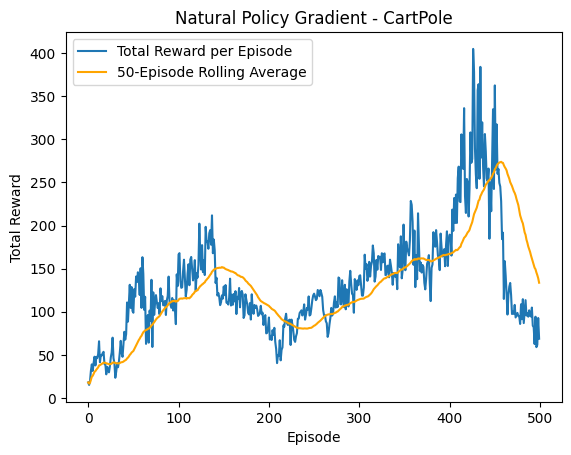

In [27]:
# Calculate the recent 50-episode interval average
window_size = 50
rolling_avg = [np.mean(total_rewards[max(0, i-window_size):(i+1)]) for i in range(len(total_rewards))]

# Plot the total rewards and rolling average over episodes
plt.plot(total_rewards, label='Total Reward per Episode')
plt.plot(rolling_avg, label=f'{window_size}-Episode Rolling Average', color='orange')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Natural Policy Gradient - CartPole')
plt.legend()
plt.show()
